In [31]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchdiffeq import odeint
from scipy.integrate import solve_ivp

Epoch 1, Loss: 176523.203125
Epoch 11, Loss: 14.312626838684082
Epoch 21, Loss: 0.04516028240323067
Training converged at epoch 24 with loss 0.007955534383654594


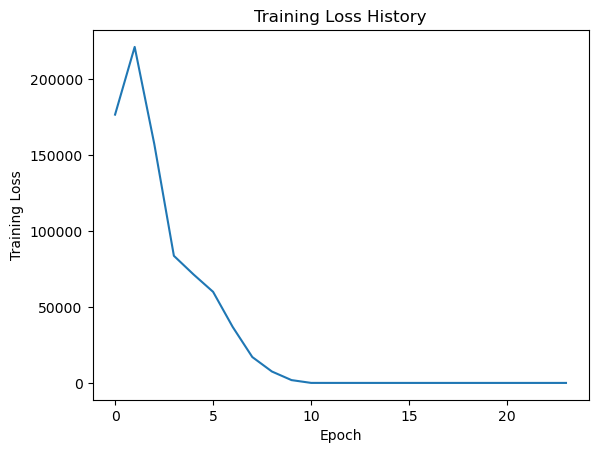

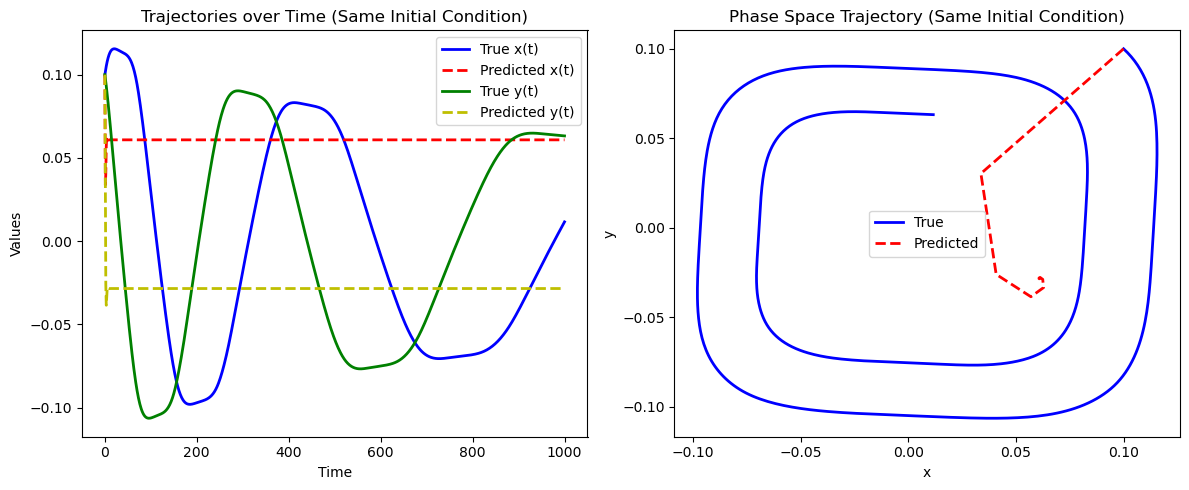

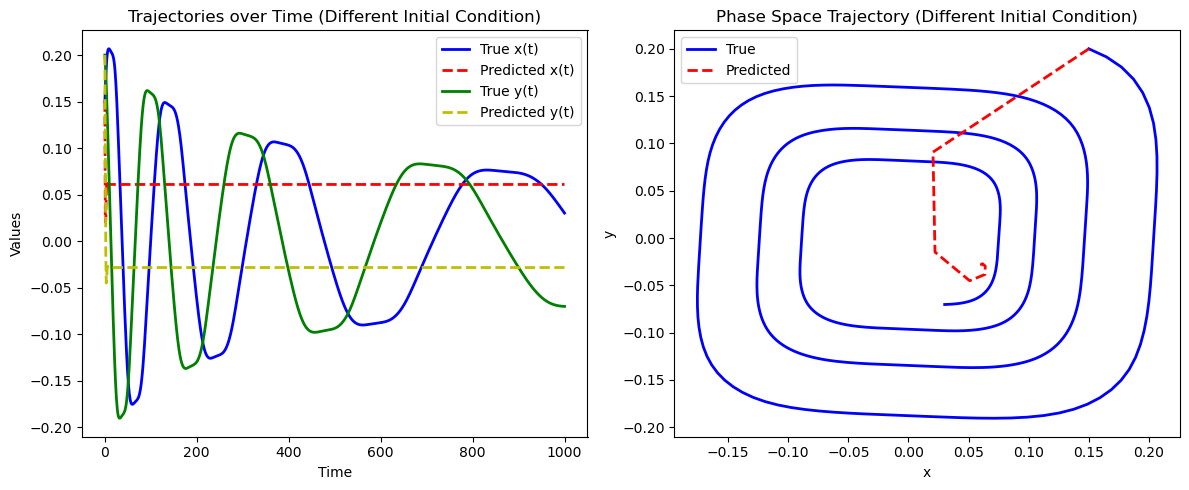

Epoch 1, Loss: 342125.9375
Epoch 11, Loss: 1.8877500295639038
Training converged at epoch 21 with loss 0.005802476312965155


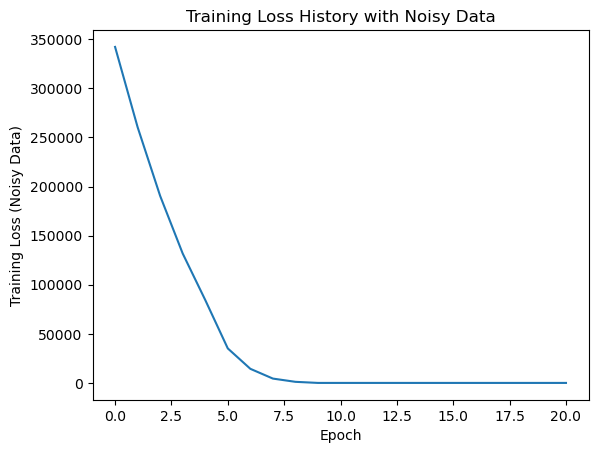

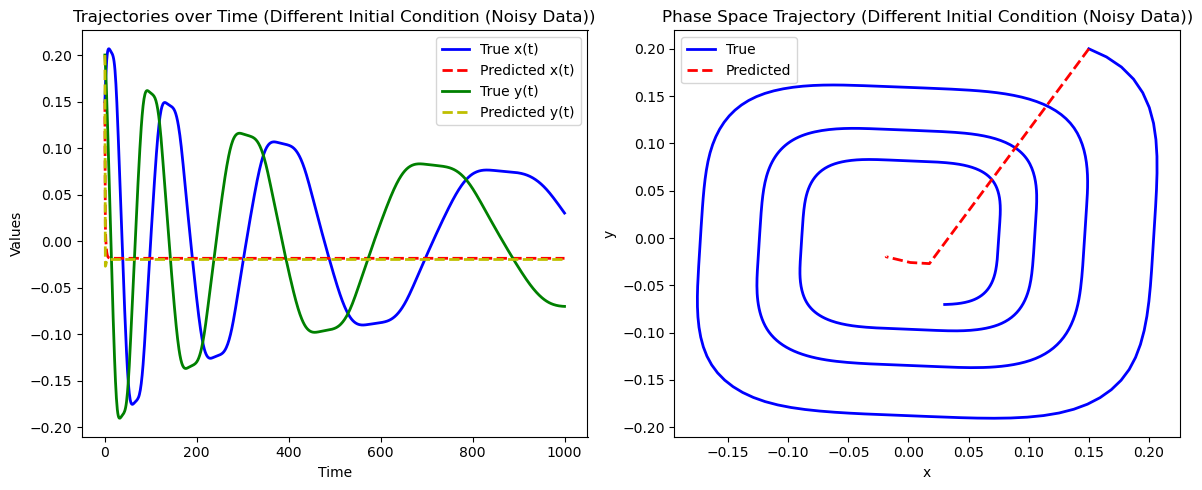

In [32]:
# Define the neural network for the ODE function
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        # Updated network architecture with more layers and neurons
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 2)
        )
        self.net.apply(self.init_weights)

    def forward(self, t, y):
        return self.net(y)

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)
            nn.init.constant_(m.bias, 0)

# Define the training function with dynamic learning rate adjustment and gradient clipping
def train_neural_ode(func, x_data, t_data, epochs=1000, lr=5e-4, loss_threshold=0.01):
    optimizer = torch.optim.Adam(func.parameters(), lr=lr, weight_decay=1e-4)  # L2 regularization
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=100, min_lr=1e-5)
    loss_fn = nn.MSELoss()
    loss_history = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        y_pred = odeint(func, x_data[0], t_data, method='dopri5', rtol=1e-4, atol=1e-4)
        loss = loss_fn(y_pred, x_data)
        loss.backward()
        
        # Apply gradient clipping
        torch.nn.utils.clip_grad_norm_(func.parameters(), max_norm=1.0)
        
        optimizer.step()
        scheduler.step(loss)  # Adjust learning rate based on loss

        loss_history.append(loss.item())

        if loss.item() <= loss_threshold:
            print(f"Training converged at epoch {epoch+1} with loss {loss.item()}")
            break

        # Print progress every 500 epochs
        if epoch % 10 == 0:
            print(f"Epoch {epoch+1}, Loss: {loss.item()}")

    return func, loss_history

# Generate data from the dynamical system
def dynamical_system(t, y):
    dxdt = -0.1 * y[0]**3 + 2 * y[1]**3
    dydt = -2 * y[0]**3 - 0.1 * y[1]**3
    return np.array([dxdt, dydt])

t_eval = np.linspace(0, 1000, 1000)
initial_state = np.array([0.1, 0.1])

# Use scipy to generate training data
sol = solve_ivp(dynamical_system, (0, 1000), initial_state, t_eval=t_eval)
x_data = torch.tensor(sol.y.T, dtype=torch.float32)
t_data = torch.tensor(t_eval, dtype=torch.float32)

# Create an ODEFunc model
func = ODEFunc()

# Train the Neural ODE model
func, loss_history = train_neural_ode(func, x_data, t_data)

# Plot the training loss
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss History')
plt.show()

# Define helper function for prediction
def predict(func, initial_state, t_eval):
    initial_state = torch.tensor(initial_state, dtype=torch.float32)
    t_data = torch.tensor(t_eval, dtype=torch.float32)
    with torch.no_grad():
        pred = odeint(func, initial_state, t_data, method='dopri5', rtol=1e-6, atol=1e-6)
    return pred.numpy()

# Compare model prediction with true system
def plot_results(sol, pred, title):
    plt.figure(figsize=(12, 5))
    # Plot trajectories over time
    plt.subplot(1, 2, 1)
    plt.plot(t_eval, sol.y[0], 'b', label='True x(t)', linewidth=2)
    plt.plot(t_eval, pred[:, 0], 'r--', label='Predicted x(t)', linewidth=2)
    plt.plot(t_eval, sol.y[1], 'g', label='True y(t)', linewidth=2)
    plt.plot(t_eval, pred[:, 1], 'y--', label='Predicted y(t)', linewidth=2)
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.legend()
    plt.title(f'Trajectories over Time ({title})')

    # Plot phase space trajectory
    plt.subplot(1, 2, 2)
    plt.plot(sol.y[0], sol.y[1], 'b', label='True', linewidth=2)
    plt.plot(pred[:, 0], pred[:, 1], 'r--', label='Predicted', linewidth=2)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.title(f'Phase Space Trajectory ({title})')
    plt.tight_layout()
    plt.show()

# Predict with the same initial condition
pred_same_ic = predict(func, initial_state, t_eval)
plot_results(sol, pred_same_ic, title="Same Initial Condition")

# Predict with a different initial condition
new_initial_state = [0.15, 0.2]
sol_new_ic = solve_ivp(dynamical_system, (0, 1000), new_initial_state, t_eval=t_eval)
pred_new_ic = predict(func, new_initial_state, t_eval)
plot_results(sol_new_ic, pred_new_ic, title="Different Initial Condition")

# Part 3(b) Add noise and retrain
noise_level = 0.02  # Reduced noise level for stability
x_data_noisy = x_data + noise_level * torch.randn_like(x_data)

# Retrain the Neural ODE with noisy data
func_noisy = ODEFunc()
func_noisy, loss_history_noisy = train_neural_ode(func_noisy, x_data_noisy, t_data)

# Plot noisy training loss
plt.plot(loss_history_noisy)
plt.xlabel('Epoch')
plt.ylabel('Training Loss (Noisy Data)')
plt.title('Training Loss History with Noisy Data')
plt.show()

# Predict with noisy model and a different initial condition
pred_new_ic_noisy = predict(func_noisy, new_initial_state, t_eval)
plot_results(sol_new_ic, pred_new_ic_noisy, title="Different Initial Condition (Noisy Data)")
